In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import ruptures as rpt

In [2]:
# Accessing the stored data
raw_us_deaths = pd.read_csv("data/RAW_us_deaths.csv")
maskData = pd.read_csv("data/mask-use-by-county.csv")
maskMandateData = pd.read_csv("data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
elPasoDeaths = raw_us_deaths[(raw_us_deaths["Province_State"] == "Colorado") & (raw_us_deaths["Admin2"] == "El Paso")]

# Extracting state and county specific data from the first 12 Columns. All remaining columns are weeks with the data filled in.
colData = elPasoDeaths[elPasoDeaths.columns[0:12]]

# The FIPS value is a unquely identifying value for a specific county
elPasoFips = colData["FIPS"].values[0]

In [3]:
# Getting the El Paso Mask Use data from the mask data by using the FIPS value
elPasoMaskUse = maskData[maskData["COUNTYFP"] == elPasoFips]

# The CDC data/mask mandate data splits the FIPS value in to a state and county value, so
# instead I use the state and county name to isolate the mask mandate data for the El Paso county
elPasoMaskMandates = maskMandateData[(maskMandateData["State_Tribe_Territory"] == "CO") & (maskMandateData['County_Name'] == 'El Paso County')]
elPasoMaskMandates["date"] = pd.to_datetime(elPasoMaskMandates["date"])

# The Face_Masks_Required_in_Public field is where if the county has a mask mandate is stored or not. Currently it is stored
# as a "Yes" or "No" string. Some early entries don't have fields filled out, so treat them as a no.
elPasoMaskMandates["Face_Masks_Required_in_Public"] = elPasoMaskMandates["Face_Masks_Required_in_Public"].fillna("No")
elPasoMaskMandates = elPasoMaskMandates.reset_index(drop = True)
print(elPasoMaskMandates.head())

  State_Tribe_Territory     County_Name  FIPS_State  FIPS_County       date  \
0                    CO  El Paso County           8           41 2020-05-26   
1                    CO  El Paso County           8           41 2020-05-27   
2                    CO  El Paso County           8           41 2020-05-28   
3                    CO  El Paso County           8           41 2020-04-10   
4                    CO  El Paso County           8           41 2020-04-11   

   order_code Face_Masks_Required_in_Public Source_of_Action  URL Citation  
0           2                            No              NaN  NaN      NaN  
1           2                            No              NaN  NaN      NaN  
2           2                            No              NaN  NaN      NaN  
3           2                            No              NaN  NaN      NaN  
4           2                            No              NaN  NaN      NaN  


C:\Users\ecorp\AppData\Local\Temp\ipykernel_25832\1263404220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elPasoMaskMandates["date"] = pd.to_datetime(elPasoMaskMandates["date"])
C:\Users\ecorp\AppData\Local\Temp\ipykernel_25832\1263404220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elPasoMaskMandates["Face_Masks_Required_in_Public"] = elPasoMaskMandates["Face_Masks_Required_in_Public"].fillna("No")


In [4]:
# I organize the El Paso death data here. Get all of the deaths by date, which are all columns after 12, then convert to a dataframe.
pasoDeathsByDate = elPasoDeaths[elPasoDeaths.columns[12:]]
pasoDeathsByDate = pd.DataFrame(pasoDeathsByDate.iloc[0])
pasoDeathsByDate = pasoDeathsByDate.reset_index()
pasoDeathsByDate.columns = ["date", "deaths"]

# Convert the date field to a date time object
pasoDeathsByDate["date"] = pd.to_datetime(pasoDeathsByDate["date"])

# Get the last date we have masking data for.
elPasoMaskMandatesSorted = elPasoMaskMandates.sort_values(by='date', ascending = True)
endDate = pd.to_datetime(elPasoMaskMandatesSorted.loc[len(elPasoMaskMandatesSorted)-1, 'date'])
print("The last date we have mask mandate data: "+str(endDate))

# Drop all data past when we have masking date. We only interested in the period we have full data for, which is
# October 15th, 2021.
pasoDeathsByDate = pasoDeathsByDate[(pasoDeathsByDate.date <= endDate)]
pasoDeathsByDate = pasoDeathsByDate.reset_index(drop = True)

# The deaths field is cumulative, so create a new field that tracks the amount of people that died that day.
pasoDeathsByDate["Deaths_A_Day"] = 0
pasoDeathsByDate.loc[0, "Deaths_A_Day"] = pasoDeathsByDate["deaths"][0]

for i in range(1, len(pasoDeathsByDate)):
    pasoDeathsByDate.loc[i, "Deaths_A_Day"] = pasoDeathsByDate["deaths"][i] - pasoDeathsByDate["deaths"][i-1]

# The El Paso deaths data frame contains more dates than the El Paso mask mandate, so do a left
# join then fill the empty values for Face_Masks_Required_in_Public as "No".
pasoDeathsByDateMerge = pd.merge(pasoDeathsByDate, elPasoMaskMandates, on='date', how='left')
pasoDeathsByDateMerge["Face_Masks_Required_in_Public"] = pasoDeathsByDateMerge["Face_Masks_Required_in_Public"].fillna("No")

print(pasoDeathsByDateMerge.head())

The last date we have mask mandate data: 2021-08-15 00:00:00
        date  deaths  Deaths_A_Day State_Tribe_Territory County_Name  \
0 2020-01-22       0             0                   NaN         NaN   
1 2020-01-23       0             0                   NaN         NaN   
2 2020-01-24       0             0                   NaN         NaN   
3 2020-01-25       0             0                   NaN         NaN   
4 2020-01-26       0             0                   NaN         NaN   

   FIPS_State  FIPS_County  order_code Face_Masks_Required_in_Public  \
0         NaN          NaN         NaN                            No   
1         NaN          NaN         NaN                            No   
2         NaN          NaN         NaN                            No   
3         NaN          NaN         NaN                            No   
4         NaN          NaN         NaN                            No   

  Source_of_Action  URL Citation  
0              NaN  NaN      NaN  
1  

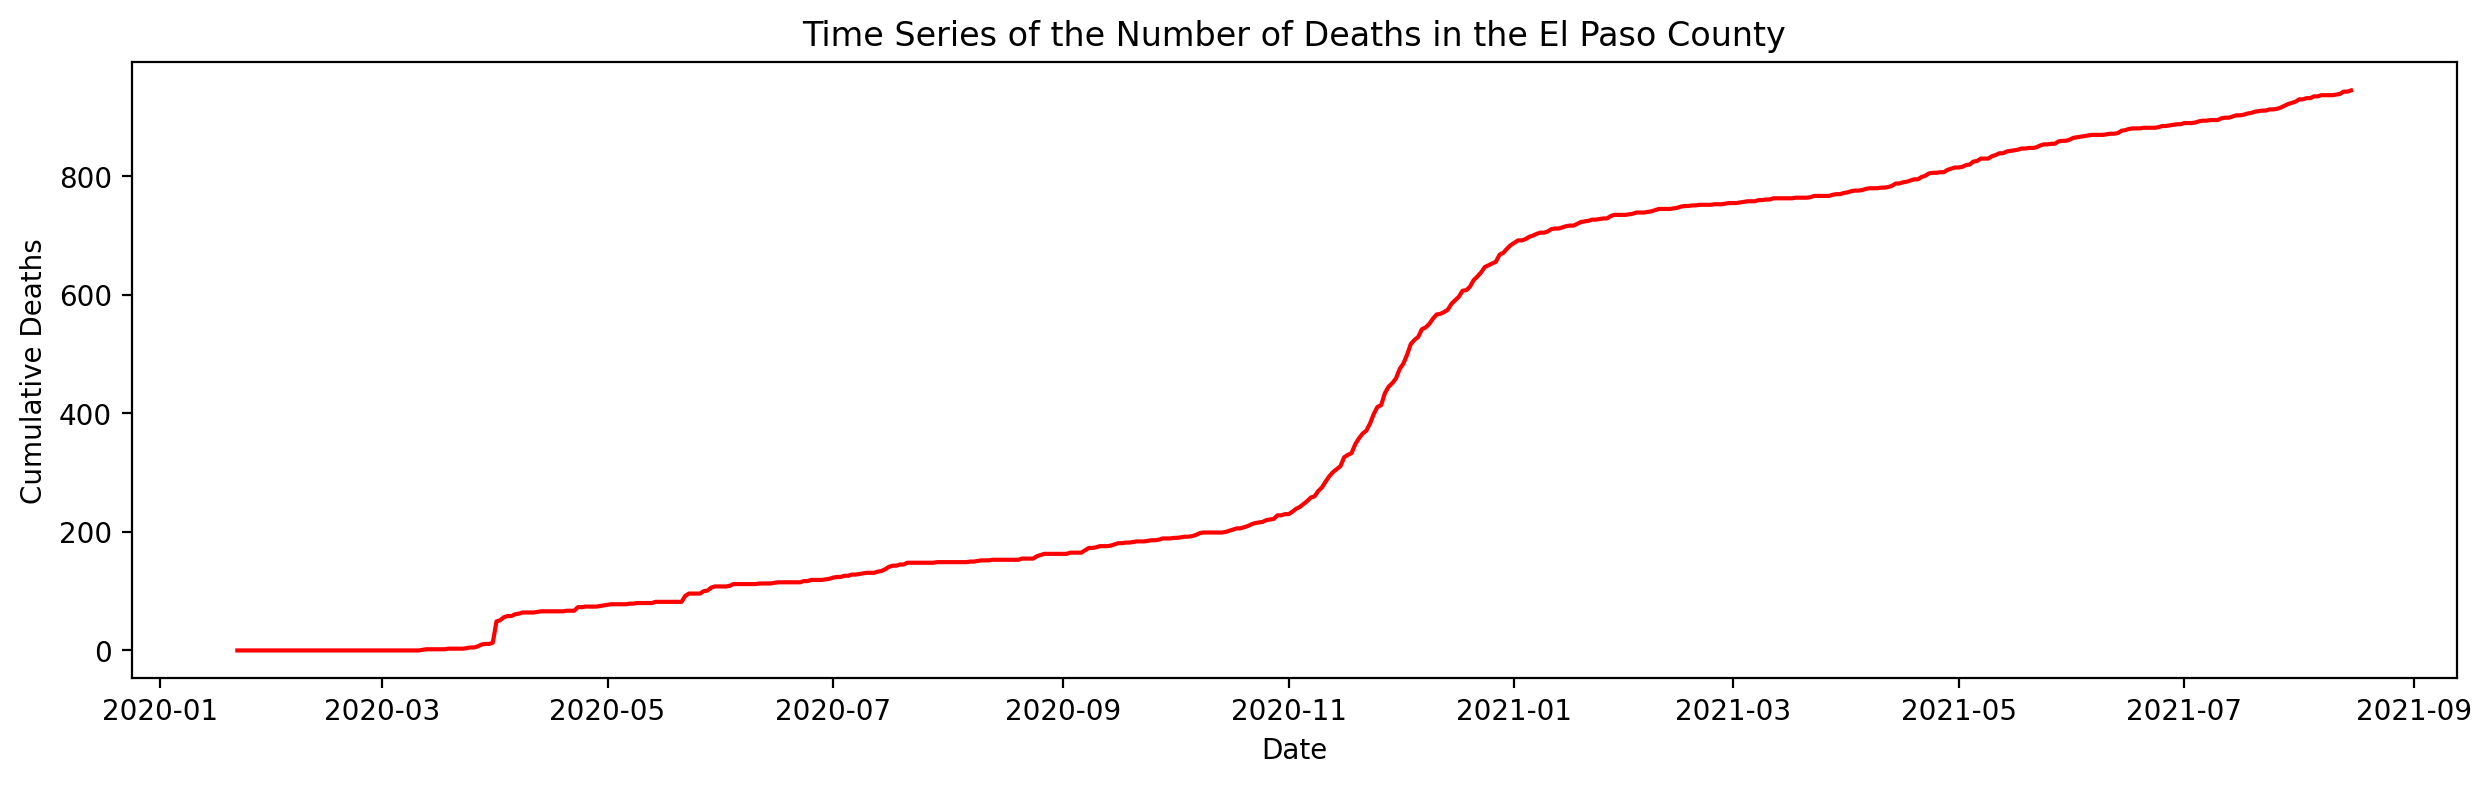

In [5]:
# Here I create an initial plot of the total deaths to get an over all idea of what the rate was like.
title = "Time Series of the Number of Deaths in the El Paso County"
xlabel = 'Date'
ylabel = 'Cumulative Deaths'
dpi = 200

plt.figure(figsize=(15,4), dpi = dpi)
plt.plot(pasoDeathsByDate["date"], pasoDeathsByDate["deaths"], 'r-')

plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

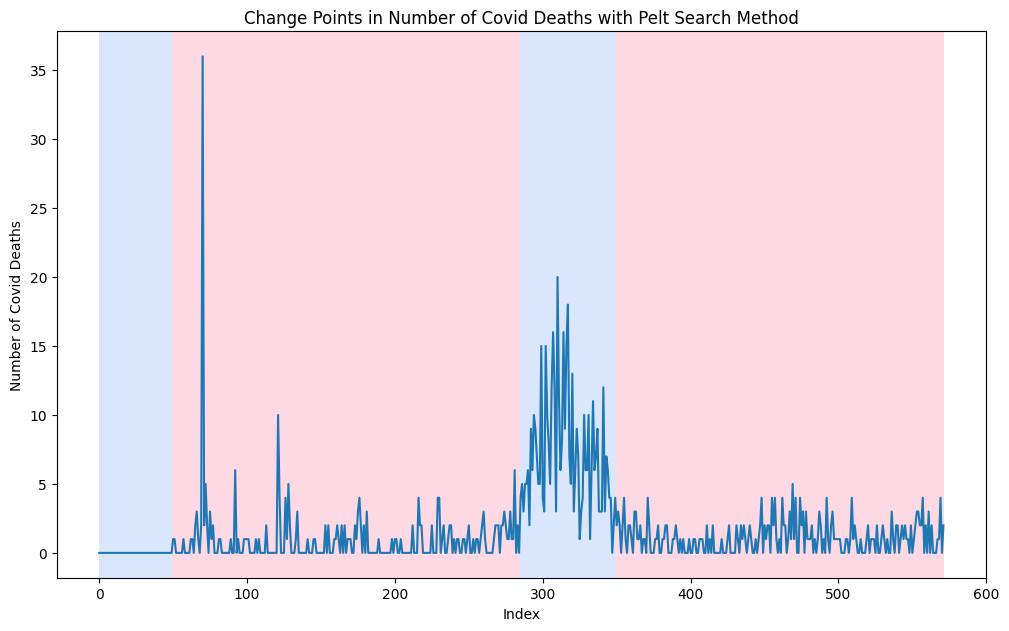

In [6]:
# To get an idea of where the significant change points are in the death rate, I
# use the PELT method to find the change points. I also use Deaths per day since
# That is what I am really interested in.

# Setting up the pelt model
deathData = np.array(pasoDeathsByDate["Deaths_A_Day"])

# I decided on a penalty value of 5 since any less than that appeared to make the
# model a little too sensitive to change points.
model="rbf"
algo = rpt.Pelt(model=model).fit(deathData)
result = algo.predict(pen=5)

# Fix the index of the break points
breaks_rpt = []
for i in result:
    breaks_rpt.append(pasoDeathsByDate.index[i-1])

# A quick display of the results to see if they make sense.
title = "Change Points in Number of Covid Deaths with Pelt Search Method"
xlabel = 'Index'
ylabel = 'Number of Covid Deaths'
dpi = 200

rpt.display(deathData, result, figsize=(10, 6))

plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()

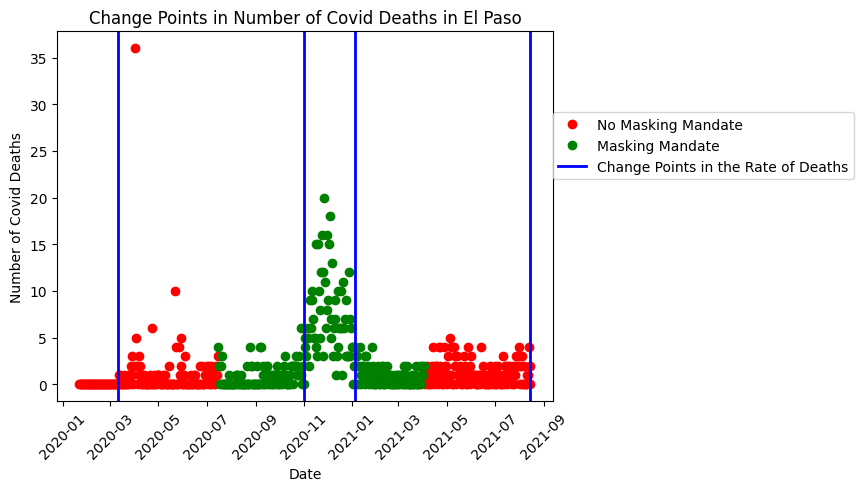

In [7]:
# To tie the change points back into masking, I decided to overlay the break points over a graph that
# differentiates between when the county was under masking rules or not.

# Split the data into two datasets, one with masking required, the other when it is not
unMasked = pasoDeathsByDateMerge[pasoDeathsByDateMerge["Face_Masks_Required_in_Public"] == "No"]
masked = pasoDeathsByDateMerge[pasoDeathsByDateMerge["Face_Masks_Required_in_Public"] == "Yes"]

# Get the change points from the Pelt method
deathData = np.array(pasoDeathsByDateMerge["Deaths_A_Day"])
model="rbf"
algo = rpt.Pelt(model=model).fit(deathData)
result = algo.predict(pen=5)
breaks_rpt = []
for i in result:
    breaks_rpt.append(pasoDeathsByDateMerge.index[i-1])

# Plot the change points over the death rate values. Color the points
# on if masking was required or not.
title = "Change Points in Number of Covid Deaths in El Paso"
xlabel = 'Date'
ylabel = 'Number of Covid Deaths'
dpi = 200

plt.plot(unMasked.date, unMasked.Deaths_A_Day, 'ro', label = "No Masking Mandate")
plt.plot(masked.date, masked.Deaths_A_Day, 'go', label = "Masking Mandate")
for x in breaks_rpt:
    plt.axvline(pasoDeathsByDate.loc[x, 'date'], lw = 2, color = 'blue', label = "Change Points in the Rate of Deaths")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels, loc = [1, .6])

plt.xticks(rotation = 45)

plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.show()